In [4]:
!pip install pyspark pandas scikit-learn matplotlib seaborn


# Step 1: Creating the Pyspark dataframe

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum as spark_sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("SalesPredictionAdvanced") \
    .getOrCreate()

# Step 1: Generate synthetic sales data
np.random.seed(42)
data = {
    'Store_Size': np.random.randint(1000, 5000, 1000),
    'Product_Price': np.random.uniform(10, 500, 1000),
    'Day_of_Week': np.random.randint(1, 8, 1000),
    'Promotion': np.random.randint(0, 2, 1000),
    'Holiday': np.random.randint(0, 2, 1000),
    'Monthly_Target': np.random.uniform(10000, 50000, 1000),
    'Sales': np.random.uniform(1000, 20000, 1000)
}
df = pd.DataFrame(data)
spark_df = spark.createDataFrame(df)

# Display initial dataset
spark_df.show(5)

+----------+------------------+-----------+---------+-------+------------------+------------------+
|Store_Size|     Product_Price|Day_of_Week|Promotion|Holiday|    Monthly_Target|             Sales|
+----------+------------------+-----------+---------+-------+------------------+------------------+
|      4174| 280.2780575465943|          5|        0|      1|12019.557776496316|13358.079727653421|
|      4507| 90.76878795713047|          7|        1|      1| 35099.46287137117| 5034.345511450934|
|      1860|211.51500712683085|          3|        0|      1| 25424.54051462592| 3318.140857960892|
|      2294| 391.0251190302605|          7|        1|      1| 47450.68557652877|14326.282425634112|
|      2130| 245.3813401145138|          7|        0|      1|31679.602995590638| 3155.375524974418|
+----------+------------------+-----------+---------+-------+------------------+------------------+
only showing top 5 rows



# Step 2: Research Questions and Graphs


## Question 1: What is the average sales per store size?

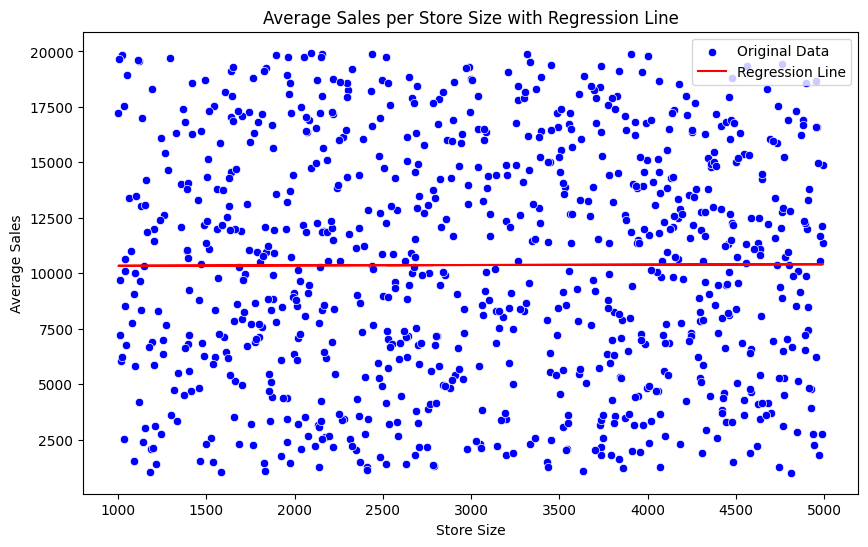

Regression Equation: Avg_Sales = 0.02 * Store_Size + 10318.55
R-squared: 0.00


In [15]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate average sales per store size
avg_sales_store = spark_df.groupBy("Store_Size").agg(avg("Sales").alias("Avg_Sales"))
avg_sales_store_pd = avg_sales_store.toPandas()

# Step 2: Prepare data for regression
X = avg_sales_store_pd[['Store_Size']].values  # Predictor variable (Store Size)
y = avg_sales_store_pd['Avg_Sales'].values  # Target variable (Average Sales)

# Fit a linear regression model
lr_model = LinearRegression()
lr_model.fit(X, y)
y_pred = lr_model.predict(X)

# Step 3: Plot the data and the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=avg_sales_store_pd, x="Store_Size", y="Avg_Sales", color="blue", label="Original Data")
plt.plot(avg_sales_store_pd["Store_Size"], y_pred, color="red", label="Regression Line")
plt.title("Average Sales per Store Size with Regression Line")
plt.xlabel("Store Size")
plt.ylabel("Average Sales")
plt.legend()
plt.show()

# Display the regression equation and R-squared value
print(f"Regression Equation: Avg_Sales = {lr_model.coef_[0]:.2f} * Store_Size + {lr_model.intercept_:.2f}")
print(f"R-squared: {lr_model.score(X, y):.2f}")


## Question 2: Does having a promotion active affect sales?

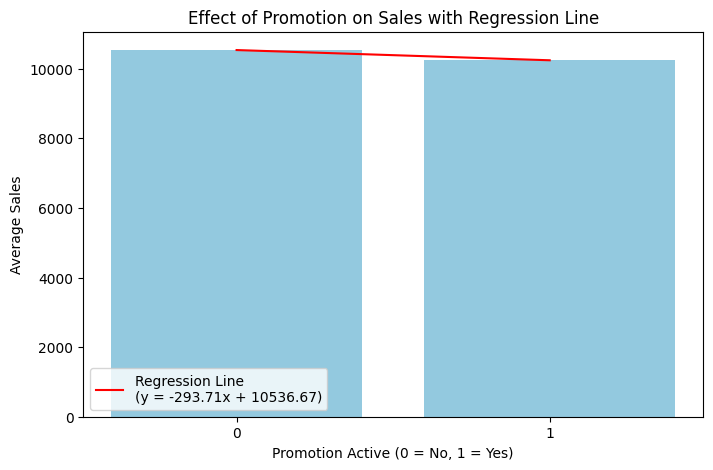

Regression Coefficient (slope): -293.71
Intercept: 10536.67


In [14]:
# Import necessary libraries for regression and plotting
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Calculate average sales for each promotion status
promo_sales = spark_df.groupBy("Promotion").agg(avg("Sales").alias("Avg_Sales"))
promo_sales_pd = promo_sales.toPandas()

# Step 2: Prepare data for linear regression
X = promo_sales_pd[['Promotion']].values  # Promotion status as predictor
y = promo_sales_pd['Avg_Sales'].values    # Average sales as target

# Fit a linear regression model
lr = LinearRegression()
lr.fit(X, y)

# Predict values across the promotion status range for the line plot
x_range = np.linspace(promo_sales_pd['Promotion'].min(), promo_sales_pd['Promotion'].max(), 100).reshape(-1, 1)
y_range = lr.predict(x_range)

# Step 3: Plot the results
plt.figure(figsize=(8, 5))

# Bar plot of average sales by promotion status
sns.barplot(data=promo_sales_pd, x="Promotion", y="Avg_Sales", color="skyblue")

# Plot regression line
plt.plot(x_range, y_range, color="red", label=f"Regression Line\n(y = {lr.coef_[0]:.2f}x + {lr.intercept_:.2f})")

# Add titles and labels
plt.title("Effect of Promotion on Sales with Regression Line")
plt.xlabel("Promotion Active (0 = No, 1 = Yes)")
plt.ylabel("Average Sales")
plt.legend()
plt.show()

# Print regression details
print(f"Regression Coefficient (slope): {lr.coef_[0]:.2f}")
print(f"Intercept: {lr.intercept_:.2f}")


## Question 3: How do sales change across different days of the week?

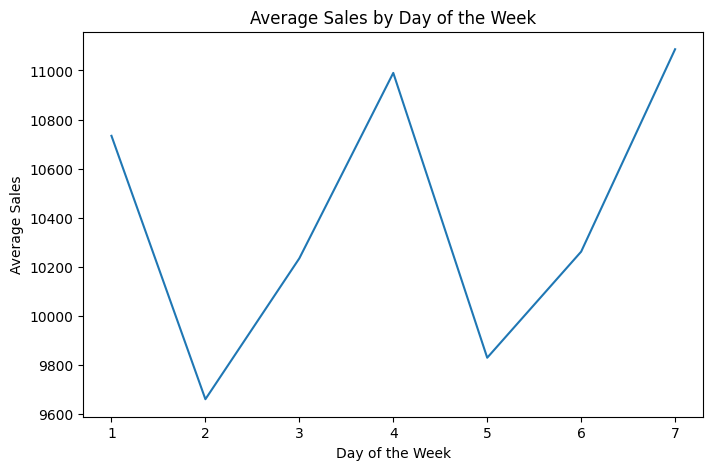

In [8]:
day_sales = spark_df.groupBy("Day_of_Week").agg(avg("Sales").alias("Avg_Sales"))
day_sales_pd = day_sales.toPandas()

plt.figure(figsize=(8, 5))
sns.lineplot(data=day_sales_pd, x="Day_of_Week", y="Avg_Sales")
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Sales")
plt.show()

## Question 4: What is the effect of holidays on sales performance?

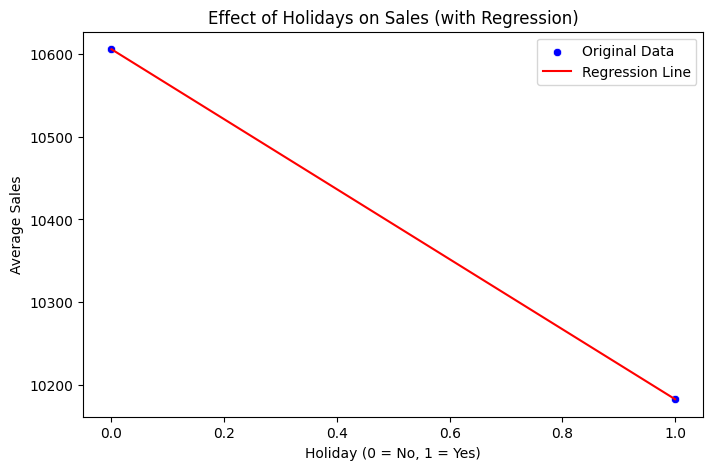

Regression Coefficient (Holiday Impact on Sales): -422.78
Intercept: 10605.59


In [13]:
# Import necessary libraries for regression and plotting
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Convert PySpark DataFrame to Pandas DataFrame
holiday_sales = spark_df.groupBy("Holiday").agg(avg("Sales").alias("Avg_Sales"))
holiday_sales_pd = holiday_sales.toPandas()

# Step 2: Prepare data for regression
X = holiday_sales_pd[['Holiday']].values  # Predictor (Holiday: 0 or 1)
y = holiday_sales_pd['Avg_Sales'].values  # Target (Average Sales)

# Step 3: Fit a Linear Regression model
regressor = LinearRegression()
regressor.fit(X, y)

# Make predictions using the model for a smooth line
X_plot = np.linspace(0, 1, 100).reshape(-1, 1)  # Generate values between 0 and 1 for prediction
y_plot = regressor.predict(X_plot)

# Step 4: Plot original data and regression line
plt.figure(figsize=(8, 5))
sns.scatterplot(data=holiday_sales_pd, x="Holiday", y="Avg_Sales", color="blue", label="Original Data")
plt.plot(X_plot, y_plot, color="red", label="Regression Line")
plt.title("Effect of Holidays on Sales (with Regression)")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Average Sales")
plt.legend()
plt.show()

# Display the regression coefficient and intercept for interpretation
print(f"Regression Coefficient (Holiday Impact on Sales): {regressor.coef_[0]:.2f}")
print(f"Intercept: {regressor.intercept_:.2f}")


## Question 5: What is the impact of meeting monthly targets on sales trends?

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for KNN: 5965.314898911593


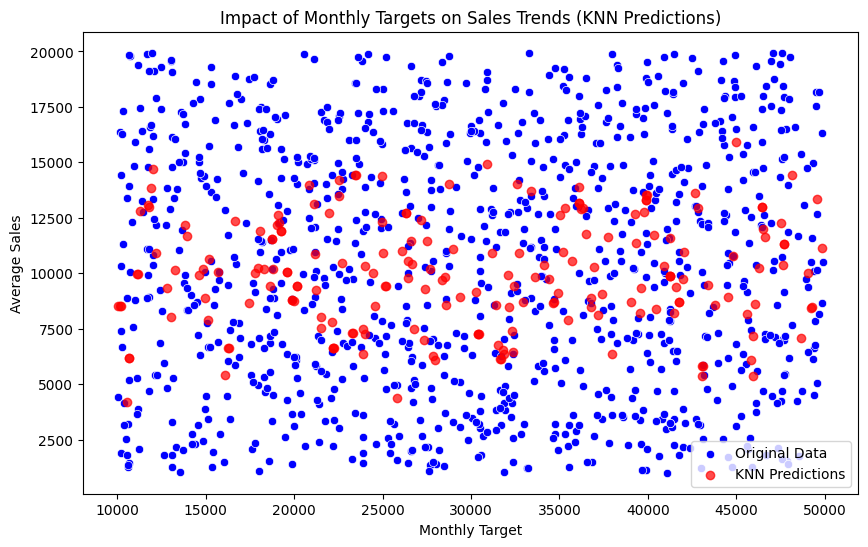

In [12]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert PySpark DataFrame to Pandas DataFrame for KNN
target_sales = spark_df.groupBy("Monthly_Target").agg(avg("Sales").alias("Avg_Sales"))
target_sales_pd = target_sales.toPandas()

# Step 2: Prepare data for KNN
X = target_sales_pd[['Monthly_Target']].values  # Predictor variable
y = target_sales_pd['Avg_Sales'].values  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Apply KNN
# Initialize the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on test data
y_pred = knn.predict(X_test)

# Calculate RMSE to evaluate model performance
rmse_knn = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE for KNN: {rmse_knn}")

# Step 4: Visualize Predictions with Original Data
# Scatter plot of original data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=target_sales_pd, x="Monthly_Target", y="Avg_Sales", color="blue", label="Original Data")

# Plot KNN predictions
plt.scatter(X_test, y_pred, color="red", label="KNN Predictions", alpha=0.7)
plt.title("Impact of Monthly Targets on Sales Trends (KNN Predictions)")
plt.xlabel("Monthly Target")
plt.ylabel("Average Sales")
plt.legend()
plt.show()
